# Day 4: Deterministic Epidemic Models
## Least Squares Parameter Estimation Using the Fourth-Order Runge–Kutta Method (RK4)

This document presents a self-contained introduction to parameter estimation in the **deterministic SIR epidemic model**.  
It includes theoretical explanations and Python implementations.

**Topics covered:**
1. The deterministic SIR model
2. Least squares estimation of infection and recovery rates
3. Numerical solution using a 4th-order Runge–Kutta (RK4) method
4. A hypothetical epidemic dataset stored in a pandas DataFrame
5. Curve fitting of the infected population
6. Estimation of the basic reproduction number $R_0$


---

## 1. The Deterministic SIR Model

The population is divided into three compartments:

- $S(t)$: susceptible individuals  
- $I(t)$: infected individuals  
- $R(t)$: removed (recovered or deceased) individuals  

The total population size is assumed constant:

$$
N = S(t) + I(t) + R(t)
$$

The deterministic SIR model is given by the system of ordinary differential equations:

$$
\begin{aligned}
\frac{dS}{dt} &= -\beta \frac{S I}{N}, \\
\frac{dI}{dt} &= \beta \frac{S I}{N} - \gamma I, \\
\frac{dR}{dt} &= \gamma I.
\end{aligned}
$$

**Parameters:**
- $ \beta $: infection (transmission) rate  
- $\gamma $: recovery rate  

---

## 2. Parameter Estimation via Least Squares

Suppose we observe the number of infected individuals at discrete times:

$$
\{(t_k, I_{\text{data}}(t_k))\}_{k=1}^n
$$

We estimate $ \beta $ and $ \gamma $ by minimizing the **least squares error**:

$$
J(\beta, \gamma)
=
\sum_{k=1}^n
\left(
I_{\text{model}}(t_k) - I_{\text{data}}(t_k)
\right)^2
$$

This approach assumes that observation errors are approximately **Gaussian** and is widely used in deterministic epidemic modeling.

---


## 3. Fourth-Order Runge–Kutta (RK4) Method

To numerically solve the SIR system, we use the **fourth-order Runge–Kutta method (RK4)**.

For a general ODE:

$$
y' = f(t,y),
$$

the RK4 update is:

$$
\begin{aligned}
k_1 &= f(t_n, y_n), \\
k_2 &= f\left(t_n + \frac{h}{2}, y_n + \frac{h}{2} k_1\right), \\
k_3 &= f\left(t_n + \frac{h}{2}, y_n + \frac{h}{2} k_2\right), \\
k_4 &= f(t_n + h, y_n + h k_3), \\
y_{n+1} &= y_n + \frac{h}{6}(k_1 + 2 k_2 + 2 k_3 + k_4)
\end{aligned}
$$

RK4 is significantly more accurate than RK2 or Euler, especially for stiff or nonlinear epidemic models.

---


---

## 4. Python Implementation

### 4.1 Imports



In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

### 4.2 SIR Right-Hand Side

In [8]:
def sir_rhs(t, y, beta, gamma, N):
    S, I, R = y
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I
    dR = gamma * I
    return np.array([dS, dI, dR])

### 4.3 RK4 Solver for the SIR Model

In [22]:
def rk4_method(f, t0, y0, h, n_steps):
    t = np.zeros(n_steps + 1)
    y = np.zeros(n_steps + 1)
    t[0], y[0] = t0, y0

    for n in range(n_steps):
        k1 = f(t[n], y[n])
        k2 = f(t[n] + h/2, y[n] + h/2*k1)
        k3 = f(t[n] + h/2, y[n] + h/2*k2)
        k4 = f(t[n] + h, y[n] + h*k3)
        y[n+1] = y[n] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        t[n+1] = t[n] + h
    
    return t, y

# 5. Hypothetical Epidemic Dataset

Assume we observe:

Daily new infected cases

The total population size

We approximate the number of infected individuals by cumulatively summing new cases.

In [23]:
tdata = np.arange(1, 21)
qdata = np.array([1, 1, 1, 1, 2, 2, 2, 2, 3, 8, 13, 19, 25, 25, 34, 52, 77, 150, 150, 198])
df=pd.DataFrame()
df["Time"]=tdata
df["Infected"]=qdata
print(df)

    Time  Infected
0      1         1
1      2         1
2      3         1
3      4         1
4      5         2
5      6         2
6      7         2
7      8         2
8      9         3
9     10         8
10    11        13
11    12        19
12    13        25
13    14        25
14    15        34
15    16        52
16    17        77
17    18       150
18    19       150
19    20       198


## 6. Least Squares Curve Fitting (Using RK2)

We estimate 
$\beta$ and 
$\gamma$ by minimizing the squared difference between the observed infected curve and the RK2-based SIR solution.

In [24]:
N = 100_000
t_data = df["Time"].values
I_data = df["Infected"].values

def loss(params):
    beta, gamma = params
    S, I, R = rk2_sir(
        beta, gamma,
        N - I_data[0], I_data[0], 0,
        N, t_data
    )
    return np.sum((I - I_data) ** 2)

result = minimize(
    loss,
    x0=[0.2, 0.2],
    bounds=[(0, 1), (0, 1)]
)

beta_hat, gamma_hat = result.x
print(f"Parameter estimation: beta = {beta_hat}, gamma = {gamma_hat}")#beta_hat, gamma_hat


Parameter estimation: beta = 0.4259623883182265, gamma = 0.14350903990560135


## 7. Data vs Fitted Curve

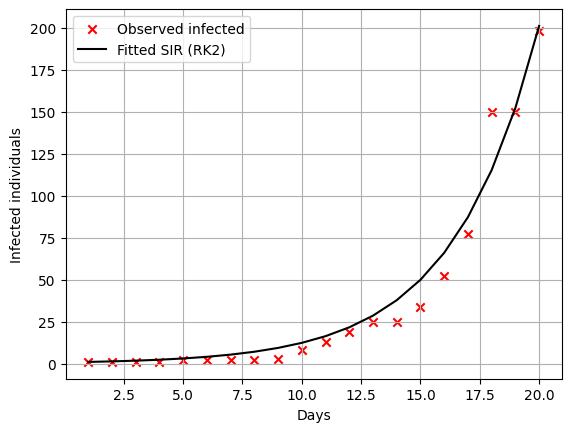

In [25]:
S_hat, I_hat, R_hat = rk2_sir(
    beta_hat, gamma_hat,
    N - I_data[0], I_data[0], 0,
    N, t_data
)

plt.figure()
plt.grid()
plt.scatter(t_data, I_data, label="Observed infected",color="red",marker="x")
plt.plot(t_data, I_hat, label="Fitted SIR (RK2)",color="black")
plt.xlabel("Days")
plt.ylabel("Infected individuals")
plt.legend()
plt.show()


## 7.1 Short predictions:

The model fit can be used to infer the number of infected

In [26]:
t_data_pred=list(t_data)+[i for i in range(21,31)]

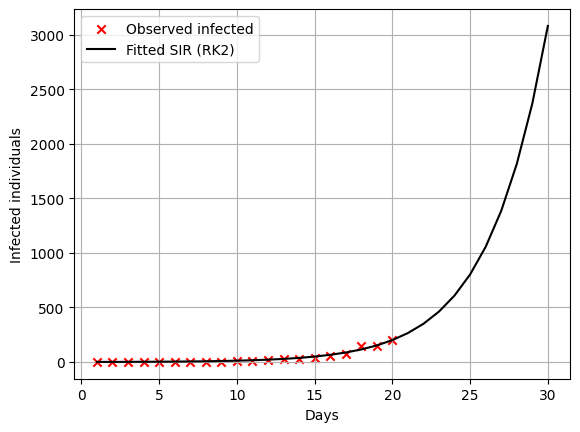

In [27]:
S_hat, I_hat_pred, R_hat = rk2_sir(
    beta_hat, gamma_hat,
    N - I_data[0], I_data[0], 0,
    N, t_data_pred
)

plt.figure()
plt.grid()
plt.scatter(t_data, I_data, label="Observed infected",color="red",marker="x")
plt.plot(t_data_pred, I_hat_pred, label="Fitted SIR (RK2)",color="black")
plt.xlabel("Days")
plt.ylabel("Infected individuals")
plt.legend()
plt.show()


## 8. Basic Reproduction Number

The basic reproduction number is defined as:
$$R_0=\frac{\beta}{\gamma}.$$



It represents the expected number of secondary infections generated by a single infected individual in a fully susceptible population.

In [28]:
R0_estimated = beta_hat / gamma_hat
print(f"Estimated R0: {R0_estimated}")


Estimated R0: 2.9681920288674486


# 9. Exercises
## Parameter Estimation, RK2, and Least Squares

This document contains exercises with solutions for deterministic epidemic models (SIR and SEIR).

---

## Exercise 1: Fit SIR model to a new dataset

**Task:**  
- Simulate a dataset with:
  - Population \(N=50000\)
  - Initial infected $I_0=5$
  - $\beta=0.25$, $\gamma=0.05$
- Use RK2 and least squares to estimate $\beta$ and $\gamma$
- Compute the basic reproduction number $R_0$

**Solution Outline:**  
1. Generate synthetic epidemic data using the RK4 solver.
2. Reconstruct infected curve using cumulative sum of new cases.
3. Define a least squares loss function comparing RK4 solution to data.
4. Optimize the loss function using `scipy.optimize.minimize`.
5. Compute $R_0 = \beta / \gamma$ from estimated parameters.
6. Compare estimated values with true parameters.

---

## Exercise 2: Compare RK2 and Euler Methods

**Task:**  
- Solve the same SIR model using both **Euler** and **RK4** methods.
- Plot solutions along with synthetic data.
- Discuss accuracy differences.

**Solution Outline:**  
1. Implement Euler method: $y_{n+1} = y_n + h f(t_n, y_n)$
2. Solve SIR model with same parameters and initial conditions using Euler.
3. Solve the same using RK4.
4. Plot all three curves: Euler, RK4, and observed data.
5. Observe that RK4 is more accurate, especially for larger step sizes.

---

## Exercise 3: Sensitivity to Initial Conditions

**Task:**  
- Change the initial infected $I_0$ to $1$ and $50$, keeping other parameters fixed.
- Fit $\beta$ and $\gamma$ to simulated data.
- Analyze how the initial condition affects parameter estimates.

**Solution Outline:**  
1. Generate synthetic datasets with different $I_0$ values.
2. Apply RK4 solver to reconstruct $I(t)$ curves.
3. Fit parameters using least squares for each dataset.
4. Compare estimated parameters: small $I_0$ may produce less reliable estimates due to low signal.
5. Note that higher $I_0$ improves identifiability in early outbreak.

---

## Exercise 4: Extend to SEIR Model

**Task:**  
- The **SEIR model** introduces an **Exposed compartment** \(E(t)\) for latent infections:

$$
\begin{aligned}
\frac{dS}{dt} &= -\beta \frac{S I}{N}, \\
\frac{dE}{dt} &= \beta \frac{S I}{N} - \sigma E, \\
\frac{dI}{dt} &= \sigma E - \gamma I, \\
\frac{dR}{dt} &= \gamma I
\end{aligned}
$$

where $\sigma$ is the rate at which exposed individuals become infectious.

**Tasks:**
1. Implement an RK4 solver for SEIR.
2. Simulate a small synthetic dataset.
3. Estimate $\beta$, $\gamma$, $\sigma$ using least squares.

**Solution Outline:**  
1. Extend RK4 function to handle four compartments: $S, E, I, R$.  
2. Generate synthetic data for $I(t)$.  
3. Define a loss function comparing simulated $I(t)$ to observed data.  
4. Optimize the loss function using `scipy.optimize.minimize`.  
5. Check estimated parameters against true values.

---

## Exercise 5: Compute $R_0$ for SEIR

**Task:**  
- Compute the **basic reproduction number** for SEIR.

**Solution Outline:**  
1. For SEIR, the basic reproduction number is usually approximated as:

$$
R_0 = \frac{\beta}{\gamma}
$$

assuming a fully susceptible population.  
2. Observe that the latent period ($\sigma^{-1}$) delays the peak but does not directly change $R_0$.  
3. Compare SEIR $R_0$ to SIR $R_0$ and discuss differences in epidemic dynamics.

---